In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
from sklearn.metrics import brier_score_loss, accuracy_score, log_loss
from sklearn.model_selection import train_test_split

import catboost

In [69]:
file = './nick_wan_hr/train.csv'

df = pd.read_csv(file)

In [54]:
# examining the columns while looking at the definitions on linked site
df.columns

Index(['uid', 'home_team', 'sz_top', 'sz_bot', 'pitch_type', 'release_pos_x',
       'release_pos_y', 'release_pos_z', 'stand', 'p_throws', 'inning',
       'inning_topbot', 'outs_when_up', 'balls', 'strikes', 'pitch_number',
       'at_bat_number', 'if_fielding_alignment', 'of_fielding_alignment',
       'on_3b', 'on_2b', 'on_1b', 'release_speed', 'spin_axis',
       'release_spin_rate', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'hc_x',
       'hc_y', 'launch_speed', 'launch_angle', 'is_hr'],
      dtype='object')

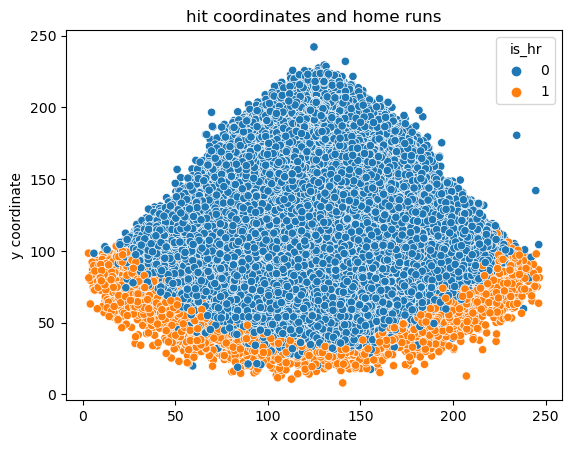

In [55]:
# since we have actual ball coordinates, let's plot them
# the plot is nice, but the coordinates not
fig, ax = plt.subplots()

sns.scatterplot(x=df['hc_x'], y=df['hc_y'], hue=df['is_hr'])
plt.title("hit coordinates and home runs")

ax.set_xlabel("x coordinate")
ax.set_ylabel("y coordinate")

plt.show()

In [75]:
# centering x and flipping y to calculate polar coordinates (distance, angle)
# from a new origin
df['hc_x_centered'] = df['hc_x'] - 125

# selecting 242 using the min of the flipped hc_y. i do not think
# home plate is at 0, but uhh we'll look into it
df['hc_y_flipped'] = 242 - df['hc_y']
df['implied_distance'] = np.sqrt(df['hc_x_centered'] ** 2 + df['hc_y_flipped'] ** 2)

# calculating radians from the new origin - this may be best as an 
# absolute value
df['angle_radians'] = np.arctan(df['hc_y_flipped'] / df['hc_x_centered'])

<Axes: xlabel='pfx_x', ylabel='pfx_z'>

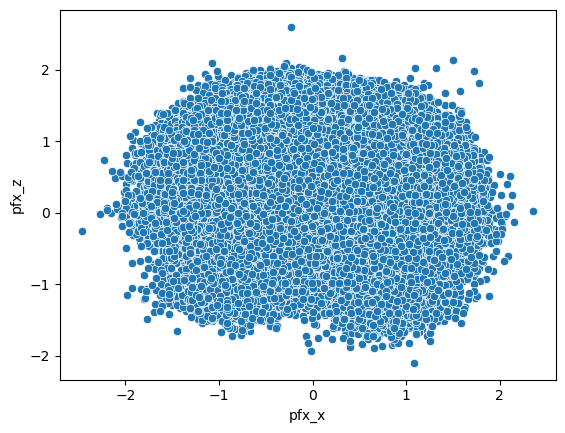

In [76]:
# plotting the x and y movement from the
# catcher's perspective. it may be worth adjusting these 
# values for the handedness of the batter.
df['lateral_movement'] = abs(df['pfx_x'])
sns.scatterplot(x=df['pfx_x'], y=df['pfx_z'])

In [78]:
# outlier detection
outlier_model = IsolationForest()

numeric_df = df.drop(columns='uid').select_dtypes(include=['number']).copy()
outlier_model.fit(numeric_df)

outlier = outlier_model.predict(numeric_df)
df['outlier'] = outlier

# looking at outlier home runs, visual scan here
df.sort_values(by=['outlier', 'is_hr'], ascending=[False, False])[['implied_distance']].head()

,implied_distance
3025,185.265298
3598,200.543403
4205,202.340914
5834,195.980828
6044,191.693274


In [79]:
# visual inspection, i'm going to eliminate this unusual hr
df = df[df['uid'] != 37812].copy()

In [80]:
categorical_columns = df.select_dtypes(exclude=['float', 'int']).columns.to_list()

In [81]:
X = df.drop(columns=['uid', 'is_hr', 'outlier'])
y = df['is_hr']

model = catboost.CatBoostClassifier(cat_features=categorical_columns)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1944)

model.fit(X, y, eval_set=(X_val, y_val), early_stopping_rounds=10, verbose=False)

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [82]:
accuracy_score(y_val, model.predict(X_val))

0.999588942554722

In [83]:
log_loss(y_test, model.predict_proba(X_test))

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0.004889335242948397

In [84]:
test_file = './nick_wan_hr/test.csv'

test_df = pd.read_csv(test_file)

# centering x and flipping y to calculate polar coordinates (distance, angle)
# from a new origin
test_df['hc_x_centered'] = test_df['hc_x'] - 125

# selecting 242 using the min of the flipped hc_y. i do not think
# home plate is at 0, but uhh we'll look into it
test_df['hc_y_flipped'] = 242 - test_df['hc_y']
test_df['implied_distance'] = np.sqrt(test_df['hc_x_centered'] ** 2 + test_df['hc_y_flipped'] ** 2)

# calculating radians from the new origin - this may be best as an 
# absolute value
test_df['angle_radians'] = np.arctan(test_df['hc_y_flipped'] / test_df['hc_x_centered'])

test_df['lateral_movement'] = abs(test_df['pfx_x'])

In [85]:
preds = model.predict(test_df.drop(columns='uid'))
test_df['is_hr'] = preds

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


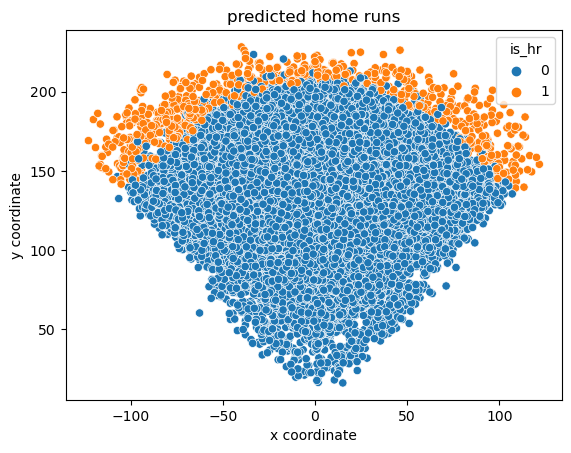

In [86]:
# plotting the predicted home run coordinates
fig, ax = plt.subplots()

sns.scatterplot(x=test_df['hc_x_centered'], y=test_df['hc_y_flipped'], hue=test_df['is_hr'])
plt.title("predicted home runs")

ax.set_xlabel("x coordinate")
ax.set_ylabel("y coordinate")

plt.show()

In [87]:
print("home run percentage in train set:", df['is_hr'].mean())
print("home run percentage in test set:", test_df['is_hr'].mean())

home run percentage in train set: 0.037335059810087556
home run percentage in test set: 0.0371


In [119]:
# initially made an error when submitting
submission = test_df[['uid', 'is_hr']].copy()

submission.head()

,uid,is_hr
0,100541,0
1,18420,0
2,29296,0
3,18753,0
4,72142,0


In [121]:
submission.to_csv('third_try.csv', index=False)